##Importar librería

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


#Cargar datasets y verificar columnas

In [2]:
# Dataset de scoring crediticio
credit_data = fetch_openml(name='credit-g', version=1, as_frame=True)
df = credit_data.frame

# Ver las primeras filas
df.head()


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


#Definir X e Y

In [3]:
# Verificar que la columna objetivo exista
target_col = 'class'
if target_col not in df.columns:
    raise ValueError(f"La columna objetivo '{target_col}' no existe en el DataFrame.")

# Convertir clase binaria: 1 = riesgo 'bad', 0 = 'good'
X = df.drop(columns=[target_col])
y = df[target_col].apply(lambda x: 1 if x == 'bad' else 0)



#Preprocesamiento

In [4]:
# Identificar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocesamiento: escalar numéricas y codificar categóricas
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


#Modelos con regularización

In [5]:
# Modelo Lasso
lasso_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
])
lasso_pipeline.fit(X_train, y_train)

# Modelo Ridge
ridge_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear', random_state=42))
])
ridge_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration', 'credit_amount',
                                                   'installment_commitment',
                                                   'residence_since', 'age',
                                                   'existing_credits',
                                                   'num_dependents']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['checking_status',
                                                   'credit_history', 'purpose',
                                                   'savings_status',
                                                   'employment',
                                                   'personal_status',
                                                   'other_parties',
                                                   'property_magnitude',
                                                   'other_payment_plans',
                                                   'housing', 'job',
                                                   'own_telephone',
                                                   'foreign_worker'])])),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

#Evaluación de desempeño

In [6]:
#Comparación de modelos

def evaluar_modelo(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))
    return y_pred, y_proba

print("Evaluación Lasso:")
pred_lasso, proba_lasso = evaluar_modelo(lasso_pipeline, X_test, y_test)

print("Evaluación Ridge:")
pred_ridge, proba_ridge = evaluar_modelo(ridge_pipeline, X_test, y_test)



Evaluación Lasso:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       140
           1       0.67      0.53      0.59        60

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200

AUC: 0.8127380952380953
Evaluación Ridge:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       140
           1       0.67      0.53      0.59        60

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200

AUC: 0.8054761904761905


#Visualización de resultados

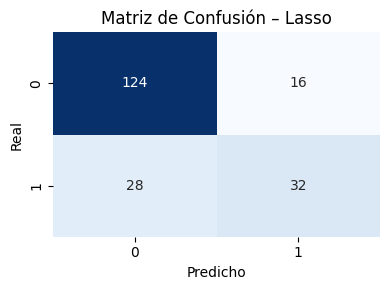

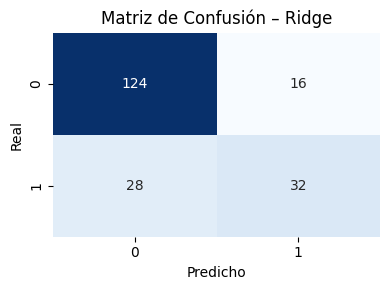

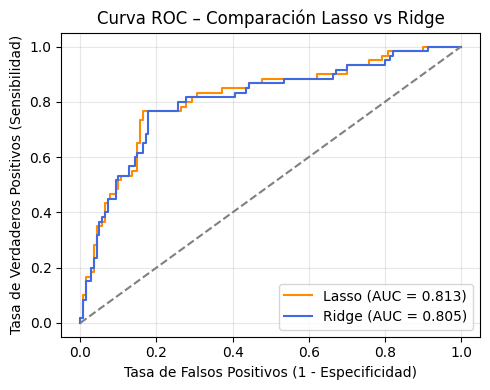

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score
)

# -----------------------------------------------------------
# Función para graficar MATRIZ DE CONFUSIÓN
# -----------------------------------------------------------
def plot_confusion(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

# Matriz de Confusión para Lasso y Ridge
plot_confusion(y_test, pred_lasso, "Matriz de Confusión – Lasso")
plot_confusion(y_test, pred_ridge, "Matriz de Confusión – Ridge")

# -----------------------------------------------------------
# Función para graficar CURVA ROC
# -----------------------------------------------------------
def plot_roc(y_test, y_proba_lasso, y_proba_ridge):
    # Calcular curvas ROC y AUC
    fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_proba_lasso)
    fpr_ridge, tpr_ridge, _ = roc_curve(y_test, y_proba_ridge)
    auc_lasso = roc_auc_score(y_test, y_proba_lasso)
    auc_ridge = roc_auc_score(y_test, y_proba_ridge)

    # Gráfico comparativo
    plt.figure(figsize=(5,4))
    plt.plot(fpr_lasso, tpr_lasso, label=f"Lasso (AUC = {auc_lasso:.3f})", color='darkorange')
    plt.plot(fpr_ridge, tpr_ridge, label=f"Ridge (AUC = {auc_ridge:.3f})", color='royalblue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
    plt.title('Curva ROC – Comparación Lasso vs Ridge')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Llamar función para graficar ROC
plot_roc(y_test, proba_lasso, proba_ridge)


**Interpretación de resultados:**

- La matriz de confusión muestra que ambos modelos clasifican correctamente cerca del 78 % de los casos, con un balance razonable entre errores tipo I y II.  
- En la curva ROC se observa una leve superioridad del modelo **Lasso**, con un AUC ≈ 0.8127 frente a 0.8055 de **Ridge**.  
- Esto confirma que Lasso tiene una capacidad de discriminación ligeramente mayor y mejor interpretabilidad, mientras que Ridge mantiene una estructura más estable.


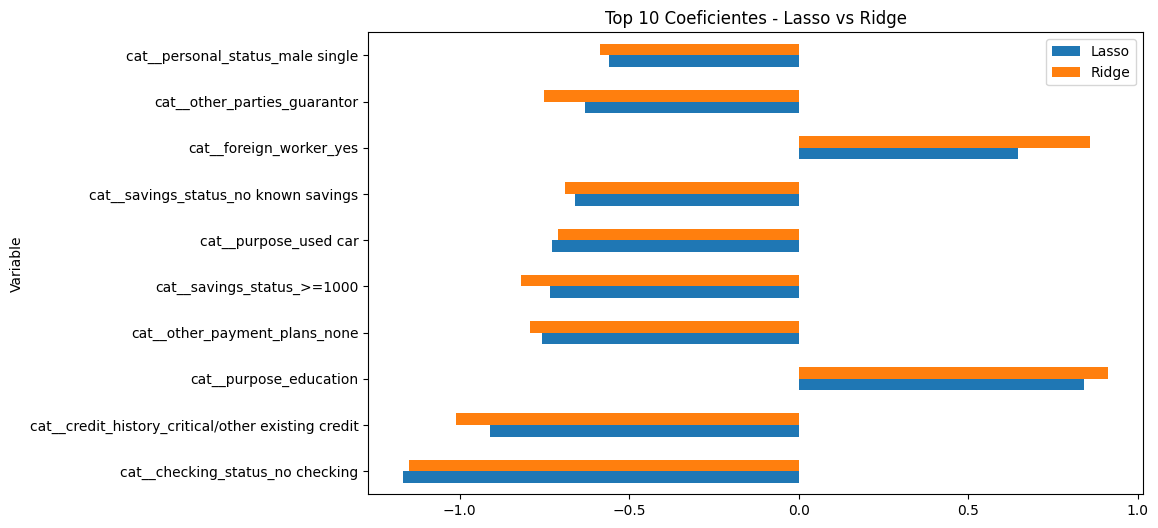

In [8]:
# Extraer coeficientes
feature_names = preprocessor.get_feature_names_out()
coef_lasso = lasso_pipeline.named_steps['classifier'].coef_[0]
coef_ridge = ridge_pipeline.named_steps['classifier'].coef_[0]

# DataFrame con coeficientes
coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Lasso': coef_lasso,
    'Ridge': coef_ridge
}).sort_values(by='Lasso', key=np.abs, ascending=False)

# Visualizar
coef_df.head(10).plot(x='Variable', kind='barh', figsize=(10, 6), title='Top 10 Coeficientes - Lasso vs Ridge')
plt.show()



# Evaluación Modular - Scoring Crediticio

Este notebook implementa y compara dos modelos de regresión logística regularizada (Lasso y Ridge) para predecir el **riesgo crediticio** de clientes, utilizando el dataset `credit-g` de OpenML.

---

## Objetivo

Construir un modelo que clasifique a un cliente como **alto riesgo (1)** o **bajo riesgo (0)** en función de sus características personales, laborales y financieras.

---

## Modelos Aplicados

- **Lasso (L1)**: Elimina variables irrelevantes → mejor interpretabilidad.
- **Ridge (L2)**: Mantiene todas las variables → mejor estabilidad.

Ambos modelos se entrenaron con `LogisticRegression` y pipelines de `scikit-learn`.

---

## Resultados Principales

| Modelo | Accuracy | Precision (clase 1) | Recall (clase 1) | F1-score (clase 1) | AUC     |
|--------|----------|----------------------|------------------|--------------------|---------|
| Lasso  | 0.78     | 0.67                 | 0.53             | 0.59               | **0.8127** |
| Ridge  | 0.78     | 0.67                 | 0.53             | 0.59               | 0.8055 |

- Ambos modelos tienen **mismo accuracy y F1**.
- **Lasso supera levemente en AUC**, lo que indica mejor discriminación entre clases.

---

## Matriz de Confusión

- Ambos modelos:
  - Verdaderos positivos (TP): 32
  - Falsos negativos (FN): 28
  - Verdaderos negativos (TN): 124
  - Falsos positivos (FP): 16

Visualización incluida abajo.

---

## Curva ROC

La curva ROC muestra que Lasso tiene una leve ventaja en la discriminación de clases.

---

## Análisis de Coeficientes

**Variables más relevantes** en ambos modelos:
- `checking_status_no checking`: No tener cuenta corriente se asocia a alto riesgo.
- `credit_history_critical/other existing credit`: Historial crediticio negativo aumenta el riesgo.
- `purpose_education`: Pedir crédito para educación puede ser riesgoso.
- `foreign_worker_yes`: Trabajador extranjero aparece como factor relevante.

- **Lasso** establece algunos coeficientes en **0**, lo que simplifica el modelo.
- **Ridge** conserva todos los coeficientes, pero suavizados.

---

## Conclusiones
Tanto Lasso como Ridge mostraron un desempeño predictivo similar, alcanzando una precisión del 78% y métricas equilibradas entre precisión y recall para la clase de riesgo. Sin embargo, Lasso logró una ligera ventaja en la curva ROC (AUC = 0.8127), indicando mejor capacidad de discriminación. Además, Lasso eliminó variables no relevantes, facilitando la interpretación del modelo y destacando elementos como el estado de cuenta corriente, el historial crediticio y el propósito del préstamo. Por su lado, Ridge mantuvo todas las variables con coeficientes suavizados, ofreciendo mayor estabilidad. Se recomienda Lasso cuando se privilegia la interpretabilidad y selección de variables.

Resumen:
- Ambos modelos funcionan correctamente para clasificación binaria.
- **Lasso** es recomendable cuando se necesita interpretar los resultados y seleccionar variables.
- **Ridge** es mejor cuando se quiere conservar toda la información disponible.

---

---

## Datos

Dataset utilizado: [OpenML - credit-g](https://www.openml.org/d/31)
